<a href="https://colab.research.google.com/github/sazad007/Grid-Demand-Forecasting-Multiple-Models/blob/main/24h_Demand_Forecasting_using_realtime_data_from_power_grid_Multiple_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import tensorflow as tf
from tensorflow.keras import backend as K

In [31]:
import warnings
warnings.filterwarnings("ignore")

In [32]:
n_feature = 1
seq_length = 24*7
forecast_horizon = 24
np.set_printoptions(suppress=True)

In [33]:
data = pd.read_csv('power-gen-load.csv')

#drop all duplicates
data.drop_duplicates(inplace=True)

#remove first row because it starts a new day that doesn't have full 24h cycle data
data.drop(0, inplace=True)
print(data.shape)

(94321, 16)


In [34]:
#parse data column into pandas datetime and remove any invalid date
data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y', errors='coerce')
data = data[data['Date'].notna()]

In [35]:
#remove any invalid data from time column
allowed_vals = ['24:00:00','00:00:00', '23:00:00', '22:00:00', '21:00:00', '20:00:00', '19:00:00', '18:00:00', '17:00:00', '16:00:00', '15:00:00', '14:00:00', '13:00:00', '12:00:00', '11:00:00', '10:00:00', '09:00:00', '08:00:00', '07:00:00', '06:00:00', '05:00:00', '04:00:00', '03:00:00', '02:00:00', '01:00:00', '9:00:00', '8:00:00', '7:00:00', '6:00:00', '5:00:00', '4:00:00', '3:00:00', '2:00:00', '1:00:00']
data = data[data['Time'].isin(allowed_vals)]

#this dataset uses 24:00:00 that is not supported by pd.
#so, replace 24:00:00 by 00:00:00 and increase the day column by 1
data.loc[data['Time'] == '24:00:00', 'Date'] = data.loc[data['Time'] == '24:00:00', 'Date'] + pd.Timedelta(days=1)

#padd with leading zeros because they are missing in dataset
data.loc[data['Time'].str.len() < 8, 'Time'] = '0' + data.loc[data['Time'].str.len() < 8, 'Time']
data.loc[data['Time'] == '24:00:00', 'Time'] = '00:00:00'

#make new datetime column with date + time
data['dateTime'] = data['Date'].astype(str) + ' ' + data['Time'].astype(str)
data['dateTime'] = pd.to_datetime(data['dateTime'], format = '%Y-%m-%d %H:%M:%S')
print(data.iloc[:50, 0:4])

         Date      Time  Generation(MW)  Demand(MW)
1  2025-08-28  23:00:00         15241.0       15241
2  2025-08-28  22:00:00         15117.0       15117
3  2025-08-28  21:00:00         15243.0       15243
4  2025-08-28  20:00:00         15278.0       15278
6  2025-08-28  19:00:00         14992.0       14992
7  2025-08-28  18:00:00         13060.0       13060
8  2025-08-28  17:00:00         13522.0       13522
9  2025-08-28  16:00:00         13853.0       13853
10 2025-08-28  15:00:00         14081.0       14081
11 2025-08-28  14:00:00         13990.0       13990
12 2025-08-28  13:00:00         14234.0       14270
13 2025-08-28  12:00:00         13862.0       13900
14 2025-08-28  11:00:00         13471.0       13510
15 2025-08-28  10:00:00         13202.0       13250
16 2025-08-28  09:00:00         13078.0       13140
17 2025-08-28  08:00:00         12858.0       12858
18 2025-08-28  07:00:00         13117.0       13117
19 2025-08-28  06:00:00         13130.0       13130
20 2025-08-2

In [36]:
#use data from 2024
formatted_data = data[['dateTime', 'Date', 'Demand(MW)']]
formatted_data = formatted_data[formatted_data['Date'].dt.year >= 2024]

#drop any duplicates from dateTime column
formatted_data = formatted_data.drop_duplicates(subset=['dateTime'])
#formatted_data = formatted_data.groupby('Date').filter(lambda x: len(x) == 24)

#index the data using datetime and set dataset freq hourly
formatted_data = formatted_data.set_index('dateTime')
formatted_data = formatted_data.asfreq('h')
#this generates hourly gapped timeseries with NaNs if the rows don't exist

In [37]:
#replace outliers with NaN and then replace with interpolate()
q75 = formatted_data['Demand(MW)'].quantile(0.80)
q25 = formatted_data['Demand(MW)'].quantile(0.20)
iqr = q75 - q25
upp = q75 + 1.5*iqr
loww = q25 - 1.5*iqr

formatted_data.loc[(formatted_data['Demand(MW)'] > upp) | (formatted_data['Demand(MW)'] < loww), 'Demand(MW)'] = np.nan

#replace missing values
formatted_data['Demand(MW)'] = formatted_data['Demand(MW)'].interpolate(method='time')

In [38]:
print(formatted_data.shape)

(14544, 2)


In [39]:
ddd = formatted_data.groupby('Date').size().sort_index(ascending=True)
print(ddd)

Date
2024-01-01    24
2024-01-02    24
2024-01-03    24
2024-01-04    24
2024-01-05    24
              ..
2025-08-24    24
2025-08-25    24
2025-08-26    24
2025-08-27    24
2025-08-28    24
Length: 606, dtype: int64


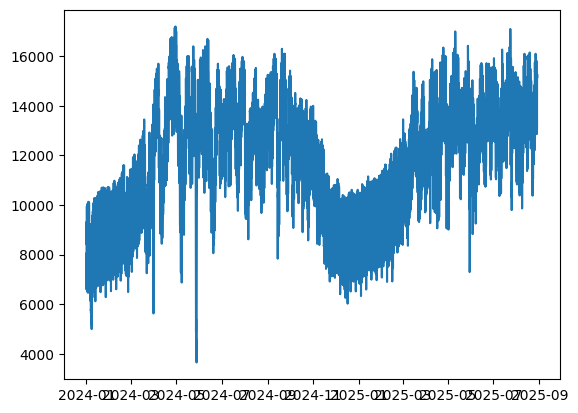

In [40]:
plt.plot(formatted_data.index, formatted_data['Demand(MW)'])
plt.show()

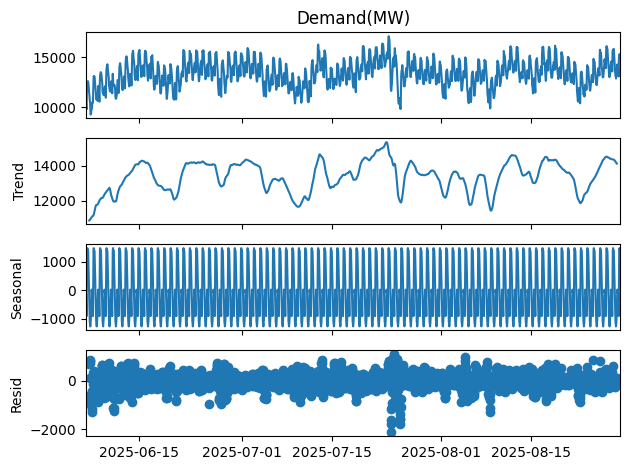

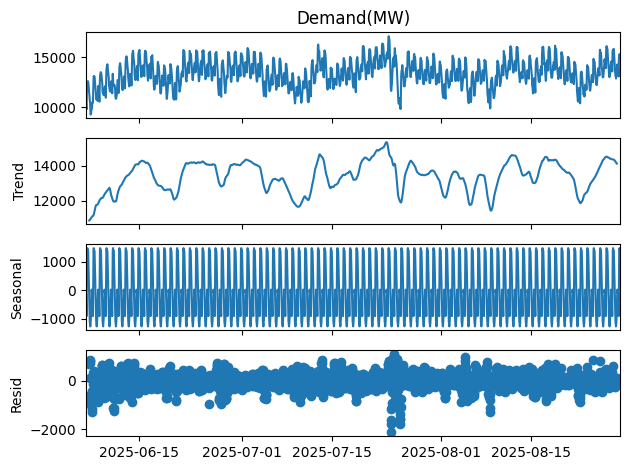

In [41]:
ssd = seasonal_decompose(formatted_data['Demand(MW)'][-2000:], model='additive', period=24)
ssd.plot()

In [42]:
for i in range(1, seq_length+1):
  formatted_data[f'lag_{i}'] = formatted_data['Demand(MW)'].shift(i).fillna(formatted_data['Demand(MW)'].expanding().mean())

for i in range(1, forecast_horizon+1):
  formatted_data[f'target_{i}'] = formatted_data['Demand(MW)'].shift(-i).fillna(formatted_data['Demand(MW)'].expanding().mean())

#formatted_data = formatted_data.fillna(0)

In [43]:
#keep last 24h data for prediction
forecast_data = formatted_data[-seq_length:]
forecast_data = forecast_data[[f'lag_{i}' for i in range(1, seq_length+1)]].values

#use rest for training
training_data = formatted_data[:-seq_length]

In [44]:
X = training_data[[f'lag_{i}' for i in range(1, seq_length+1)]]
y = training_data[[f'target_{i}' for i in range(1, forecast_horizon+1)]]

split = 0.8
index = int(len(X)*split)

X_train = X[:index].values
y_train = y[:index].values

X_test = X[index:].values
y_test = y[index:].values

In [45]:
#actual demand from PGCB on 29th Aug
actual_29th = [15150, 14795, 14338, 13860, 13581, 13364, 12546, 12100, 11829, 11547, 11460, 11617, 12219, 12854, 12282, 12274, 11511, 11165, 11178, 13521, 14029, 14138, 14235, 14397]
rmse_errors = {'XGBoost': 0, 'Ensemble': 0, 'LightGBM': 0, 'DL': 0}

def plot(x1, x2, title):
  plt.figure(figsize=(12,6))
  plt.plot(range(len(x2)), x2, color='red', label = 'Predicted load')
  plt.plot(range(len(x1)), x1, color='green', label = 'Actual load')
  plt.xlabel('Hours, 00:00 to 23:00')
  plt.ylabel('Demand(MW)')
  plt.title(title)
  plt.legend()
  plt.show()

In [46]:
xgb = MultiOutputRegressor(XGBRegressor())
xgb.fit(X_train, y_train)

MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None,
                                            feature_weights=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None, ...))

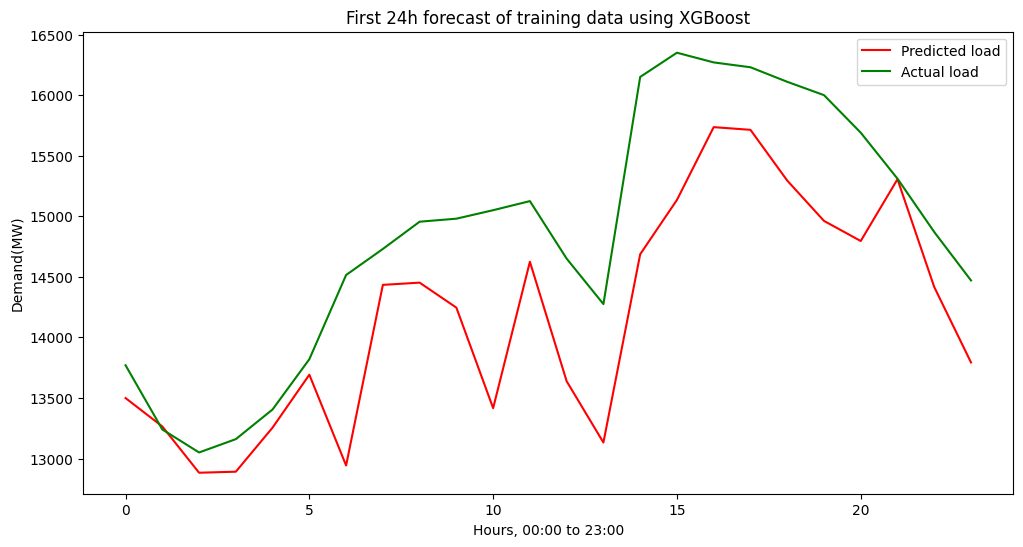

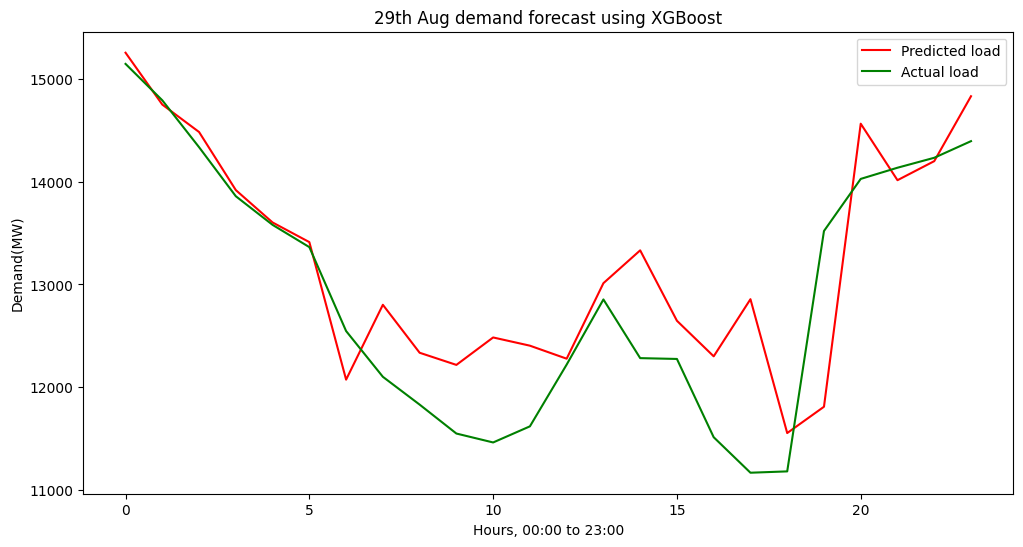

RMSE for XGBoost:  690.7893356516153


In [47]:
y_pred = xgb.predict(X_test)
y_p = y_pred[0]
y_t = y_test[0]
plot(y_t, y_p, 'First 24h forecast of training data using XGBoost')

y_pred = xgb.predict(forecast_data)
y_p = y_pred[-1]
plot(actual_29th, y_p, '29th Aug demand forecast using XGBoost')

mse = mean_squared_error(actual_29th, y_p)
print('RMSE for XGBoost: ', np.sqrt(mse))
rmse_errors['XGBoost'] = np.sqrt(mse)

In [48]:
rf = MultiOutputRegressor(ExtraTreesRegressor(n_estimators=50, max_depth=8, n_jobs=-1), n_jobs=-1)
rf.fit(X_train, y_train)

MultiOutputRegressor(estimator=ExtraTreesRegressor(max_depth=8, n_estimators=50,
                                                   n_jobs=-1),
                     n_jobs=-1)

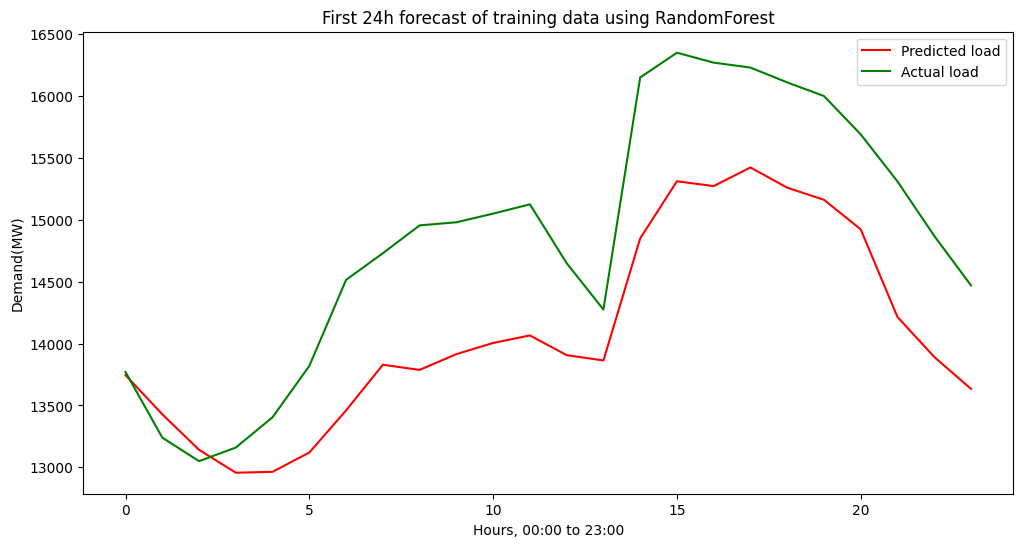

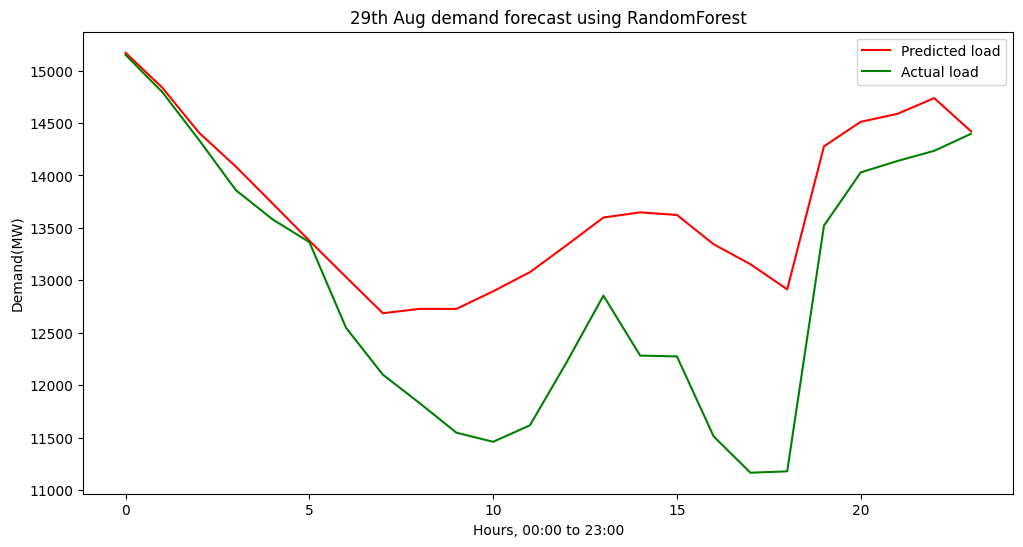

RMSE for RandomForest:  1002.565597313432


In [49]:
y_pred = rf.predict(X_test)
y_p = y_pred[0]
y_t = y_test[0]
plot(y_t, y_p, 'First 24h forecast of training data using RandomForest')

y_pred = rf.predict(forecast_data)
y_p = y_pred[-1]
plot(actual_29th, y_p, '29th Aug demand forecast using RandomForest')

mse = mean_squared_error(actual_29th, y_p)
print('RMSE for RandomForest: ', np.sqrt(mse))
rmse_errors['Ensemble'] = np.sqrt(mse)

In [50]:
lgbm = MultiOutputRegressor(LGBMRegressor(verbosity=-1))
lgbm.fit(X_train, y_train)

MultiOutputRegressor(estimator=LGBMRegressor(verbosity=-1))

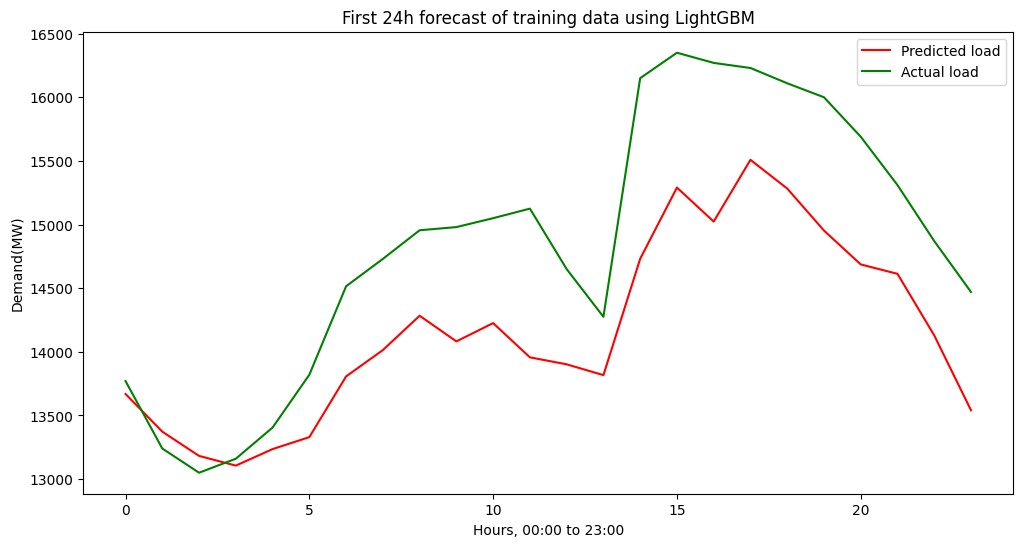

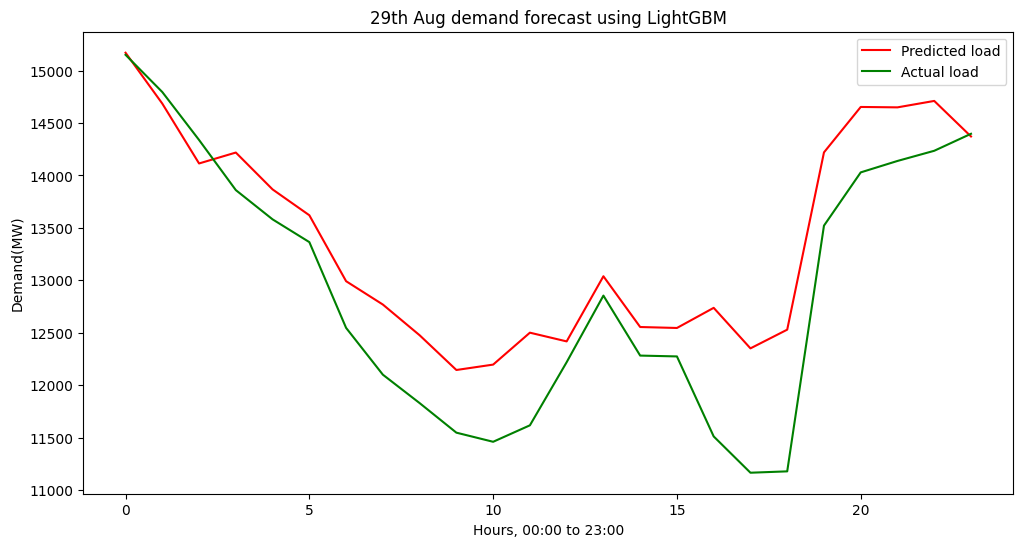

RMSE for LightGBM:  625.9438442195164


In [51]:
y_pred = lgbm.predict(X_test)
y_p = y_pred[0]
y_t = y_test[0]
plot(y_t, y_p, 'First 24h forecast of training data using LightGBM')

y_pred = lgbm.predict(forecast_data)
y_p = y_pred[-1]
plot(actual_29th, y_p, '29th Aug demand forecast using LightGBM')

mse = mean_squared_error(actual_29th, y_p)
print('RMSE for LightGBM: ', np.sqrt(mse))
rmse_errors['LightGBM'] = np.sqrt(mse)

In [52]:
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_true - y_pred)))

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=24),
])

model.compile(optimizer='adam', loss='mse', metrics=[rmse])
history = model.fit(x=X, y=y, epochs=50, validation_data=(X_test, y_test))

Epoch 1/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 13811572.0000 - rmse: 2724.3335 - val_loss: 1700329.3750 - val_rmse: 1252.4325
Epoch 2/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 1452479.8750 - rmse: 1193.7571 - val_loss: 1183893.6250 - val_rmse: 1017.1291
Epoch 3/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 1106088.1250 - rmse: 1037.4468 - val_loss: 1114506.0000 - val_rmse: 978.4155
Epoch 4/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 1013531.8750 - rmse: 991.5483 - val_loss: 1054042.2500 - val_rmse: 952.1353
Epoch 5/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 915029.1875 - rmse: 944.4645 - val_loss: 1424209.8750 - val_rmse: 1140.9045
Epoch 6/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 966543.9375 - rmse: 969.3229 - val_loss: 988118.6250 - val_rmse: 910.0367
Epoch 7/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 896934.6875 - rmse: 930.6254 - val_loss: 922999.7500 - val_rmse: 881.3209
Epoch 8/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 7m

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


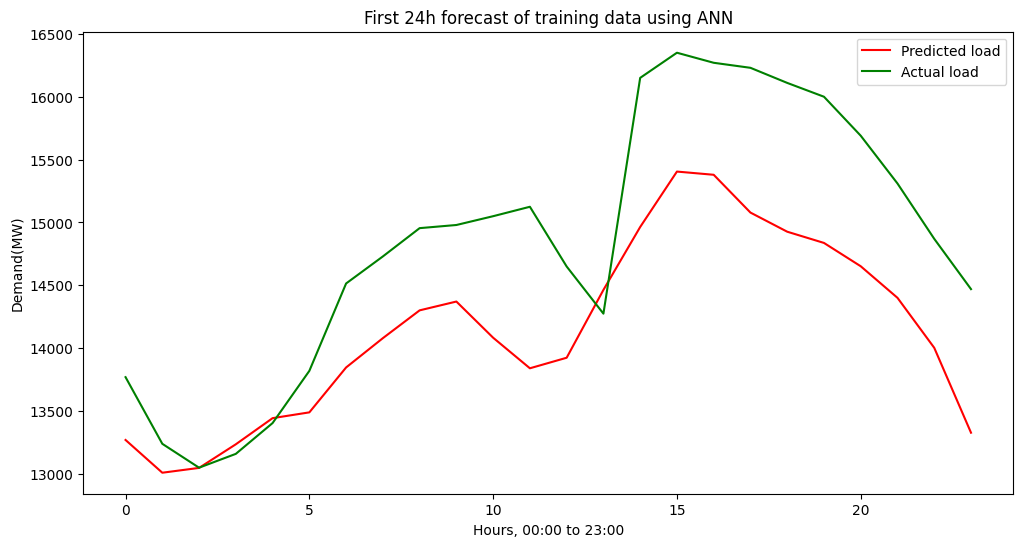

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


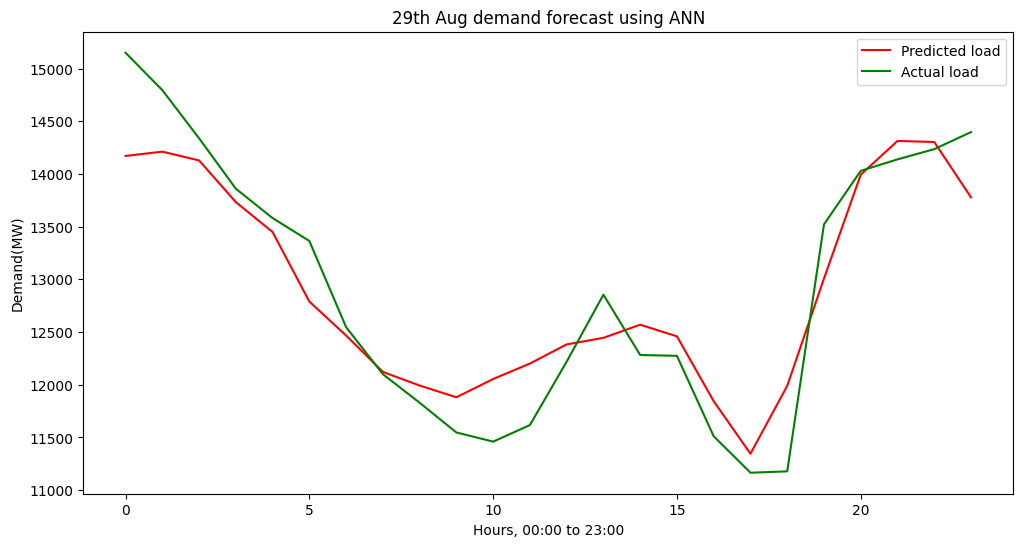

Last epoch validation RMSE:  847.805908203125


In [53]:
y_pred = model.predict(X_test)
y_p = y_pred[0]
y_t = y_test[0]
plot(y_t, y_p, 'First 24h forecast of training data using ANN')

y_pred = model.predict(forecast_data)
y_p = y_pred[-1]
plot(actual_29th, y_p, '29th Aug demand forecast using ANN')

print('Last epoch validation RMSE: ', history.history['val_rmse'][-1])
rmse_errors['DL'] = history.history['val_rmse'][-1]

In [54]:
best_model = min(rmse_errors, key=rmse_errors.get)
best_value = rmse_errors[best_model]

print("Best model:", best_model)
print("Lowest RMSE:", best_value)

Best model: LightGBM
Lowest RMSE: 625.9438442195164
